# GPU Acceleration

This notebook is intended to demonstrate GPU-acceleration of `superscreen` models.

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import logging

logging.basicConfig(level=logging.INFO)

import jax
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

import superscreen as sc
from superscreen.geometry import circle, box

## Superconducting ring

In [2]:
length_units = "um"
ro = 3  # outer radius
ri = 1  # inner radius
slit_width = 0.25
layer = sc.Layer("base", london_lambda=0.100, thickness=0.025, z0=0)

ring = circle(ro)
hole = circle(ri)
bounding_box = sc.Polygon("bounding_box", layer="base", points=circle(1.2 * ro))

In [3]:
device = sc.Device(
    "ring",
    layers=[sc.Layer("base", london_lambda=0.100, thickness=0.025, z0=0)],
    films=[sc.Polygon("ring", layer="base", points=ring)],
    holes=[sc.Polygon("hole", layer="base", points=hole)],
    abstract_regions=[bounding_box],
    length_units=length_units,
)

In [4]:
device.make_mesh(min_points=4_000, optimesh_steps=10)

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Optimizing mesh with 4150 vertices.
<string>:367: UserWarning: After 2 edge flip steps, there are 1 remaining non-Delaunay facets. The signed circumcenter distances are [-3.469446951953614e-17]. This can happen due to round-off errors or to prevent non-manifold edges in shell meshes.
INFO:superscreen.device.device:Finished generating mesh with 4150 points and 8112 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.device.device:Calculating gradient matrix.


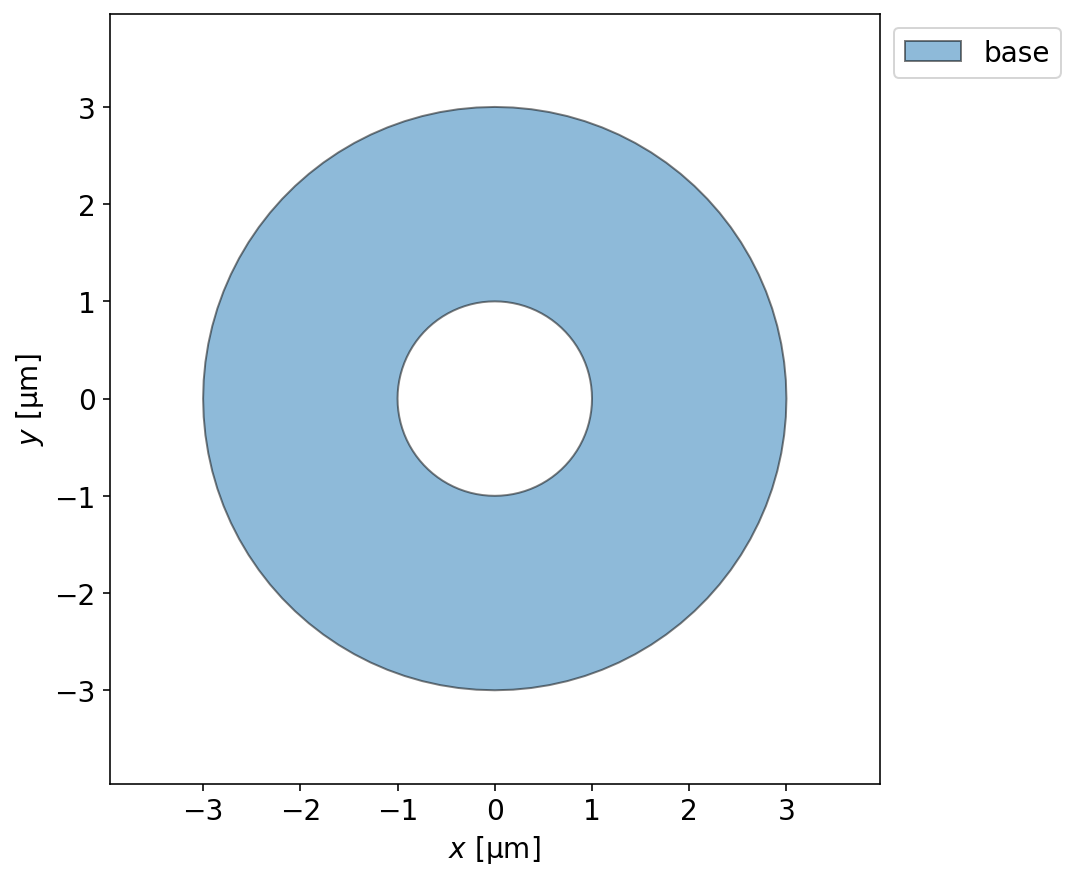

In [5]:
fig, ax = device.draw(exclude="bounding_box", legend=True)

In [6]:
xs = np.linspace(-3.5, 3.5, 401)

cross_section_coords = [
    # [x-coords, y-coords]
    np.stack([xs, 0 * xs], axis=1),  # horizontal cross-section
    np.stack([xs, -2 * np.ones_like(xs)], axis=1),  # horizontal cross-section
    np.stack([0 * xs, xs], axis=1),  # vertical cross-section
]

### Trapped flux

We can also solve for the field and current distribution from circulating currents associated with flux trapped in the hole.

We assume there is a total current of 1 mA circulating clockwise in the ring (associated with some positive net trapped flux), and that there is otherwise no applied magnetic field. From here we can calculate the current distribution in the ring, the total magnetic field in the plane of the ring, and the flux through the ring.

Note that, although here we are assuming no applied field, we can also solve models with both trapped flux and applied fields.

In [7]:
circulating_currents = {"hole": "1 mA"}
kwargs = dict(
    circulating_currents=circulating_currents,
    field_units="mT",
    current_units="mA",
)

#### NumPy (CPU)

In [8]:
%timeit sc.solve(device,**kwargs); clear_output(wait=True)

737 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### JAX (CPU)

In [9]:
with jax.default_device(jax.devices("cpu")[0]):
    %timeit sc.solve(device, gpu=True, **kwargs); clear_output(wait=True)

757 ms ± 8.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### JAX (GPU if available)

In [10]:
if "cpu" in jax.devices()[0].device_kind:
    print("Skipping because there is no GPU available.")
else:
    %timeit sc.solve(device, gpu=True, **kwargs); clear_output(wait=True)

311 ms ± 6.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


INFO:superscreen.solve:Calculating base response to applied field.


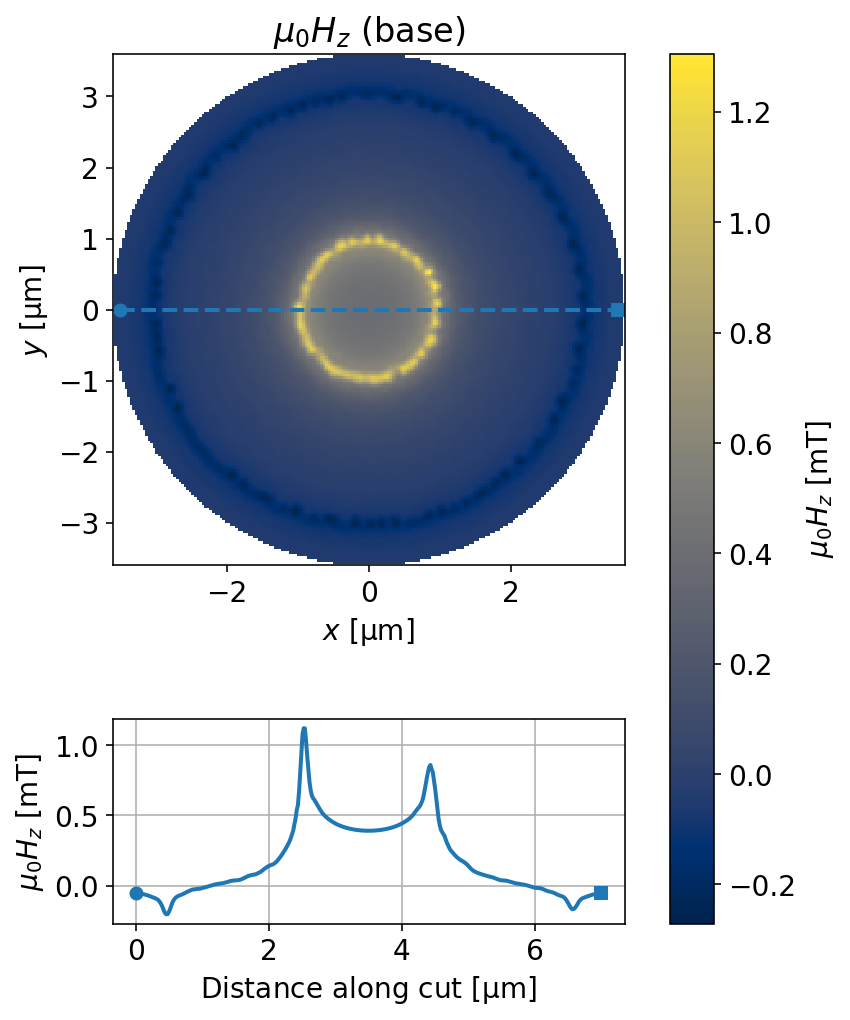

In [11]:
solution = sc.solve(device, **kwargs)[-1]

fig, axes = solution.plot_fields(
    cross_section_coords=cross_section_coords[:1], figsize=(6, 8)
)

### Solve for a specific fluxoid state: $\Phi^f=n\Phi_0$

Current and field distributions for a given fluxoid state $\Phi^f=n\Phi_0$, where $\Phi_0$ is the superconducting flux quantum, can be modeled by adjusting the circulating current $I_\mathrm{circ}$ to realize the desired fluxoid value. This calculation is performed by the function `superscreen.find_fluxoid_solution()`.

Here we solve for the current distribution in the ring for the $n=0$ fluxoid state (i.e. Meissner state), which can be achieved by cooling the ring through its superconducting transition with no applied field. If a small field is then applied, it is screened by the ring such that the fluxoid remains zero.

In [12]:
kwargs = dict(
    fluxoids=dict(hole=0),
    applied_field=sc.sources.ConstantField(1),
    field_units="mT",
    current_units="mA",
)

#### NumPy (CPU)

In [13]:
%timeit sc.find_fluxoid_solution(device, **kwargs); clear_output(wait=True)

6.53 s ± 46.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### JAX (CPU)

In [14]:
with jax.default_device(jax.devices("cpu")[0]):
    %timeit sc.find_fluxoid_solution(device, gpu=True, **kwargs); clear_output(wait=True)

9.05 s ± 30.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### JAX (GPU if available)

In [15]:
if "cpu" in jax.devices()[0].device_kind:
    print("Skipping because there is no GPU available.")
else:
    %timeit sc.find_fluxoid_solution(device, gpu=True, **kwargs); clear_output(wait=True)

14.2 s ± 30.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
# n = 0 fluxoid state, apply a field of 1 mT
solution, result = sc.find_fluxoid_solution(device, **kwargs)
I_circ = solution.circulating_currents["hole"]
fluxoid = sum(solution.hole_fluxoid("hole")).to("Phi_0").magnitude
print("Root finding result:\n", result)
print(f"Total circulating current: {I_circ:.3f} mA.")
print(f"Total fluxoid: {fluxoid:.6f} Phi_0.")

INFO:superscreen.fluxoid:Finding fluxoid solution using root finding...
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.


Root finding result:
       converged: True
           flag: 'converged'
 function_calls: 3
     iterations: 2
           root: -1.8131551798206074
Total circulating current: -1.813 mA.
Total fluxoid: -0.000000 Phi_0.


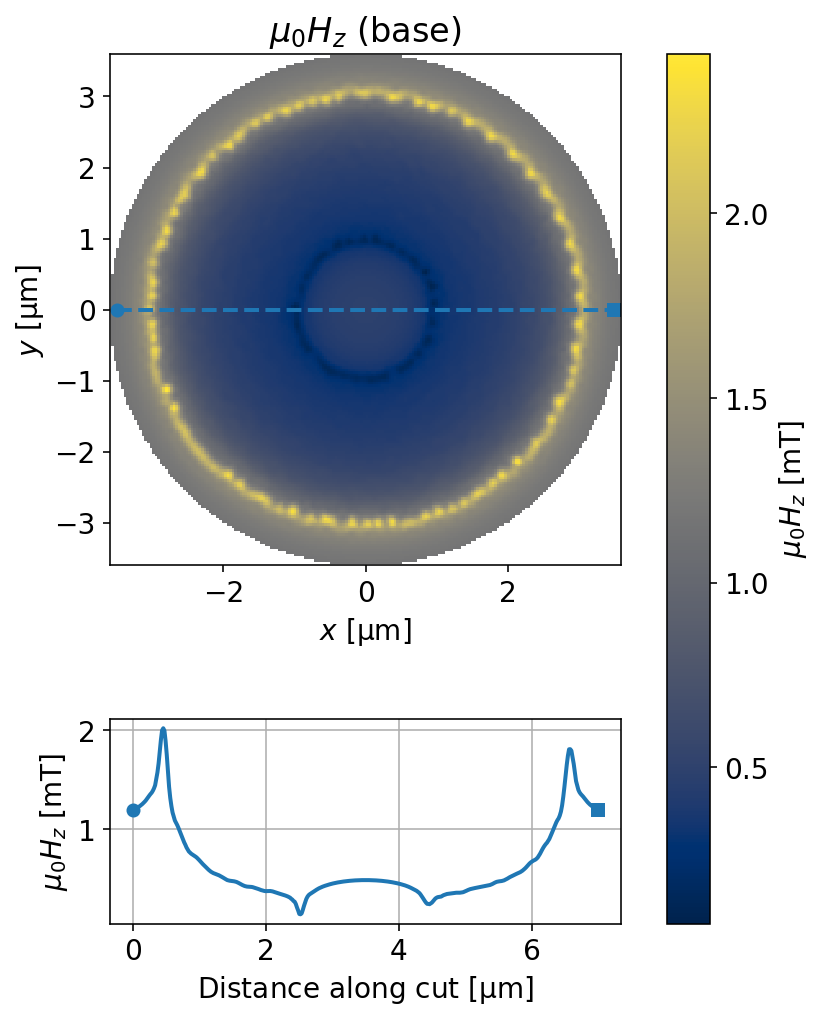

In [17]:
fig, axes = solution.plot_fields(
    cross_section_coords=cross_section_coords[:1], figsize=(6, 8)
)

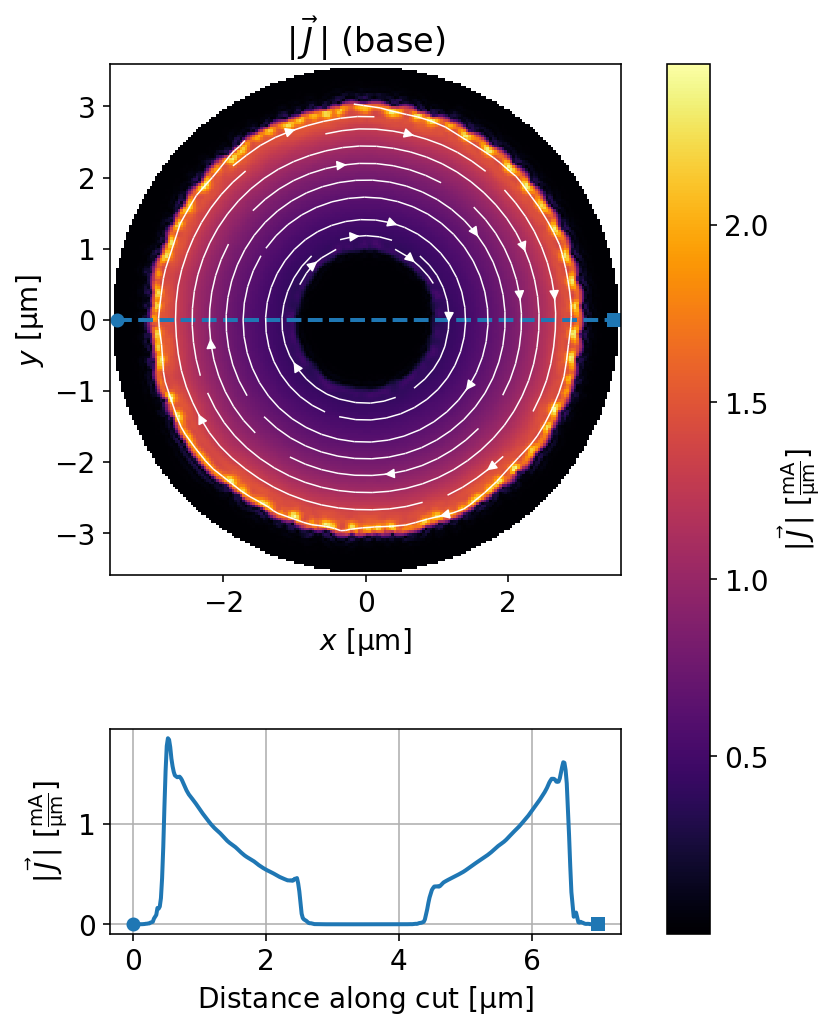

In [18]:
fig, axes = solution.plot_currents(
    cross_section_coords=cross_section_coords[:1], figsize=(6, 8)
)

## Film with multiple holes

Here we simulate a device with fewer symmetries than the ring, namely a rectangular film with two off-center rectangular holes.

In [19]:
length_units = "um"

layers = [
    sc.Layer("base", Lambda=0.1, z0=0),
]

films = [
    sc.Polygon("film", layer="base", points=box(8, 4)),
]

holes = [
    sc.Polygon("hole0", layer="base", points=box(5, 1, center=(0.5, -0.25))).resample(
        101
    ),
    sc.Polygon("hole1", layer="base", points=box(1, 2.5, center=(-3, 0.25))).resample(
        51
    ),
]

abstract_regions = [
    sc.Polygon("bounding_box", layer="base", points=box(9, 5)),
]

device = sc.Device(
    "rect",
    layers=layers,
    films=films,
    holes=holes,
    abstract_regions=abstract_regions,
    length_units=length_units,
)

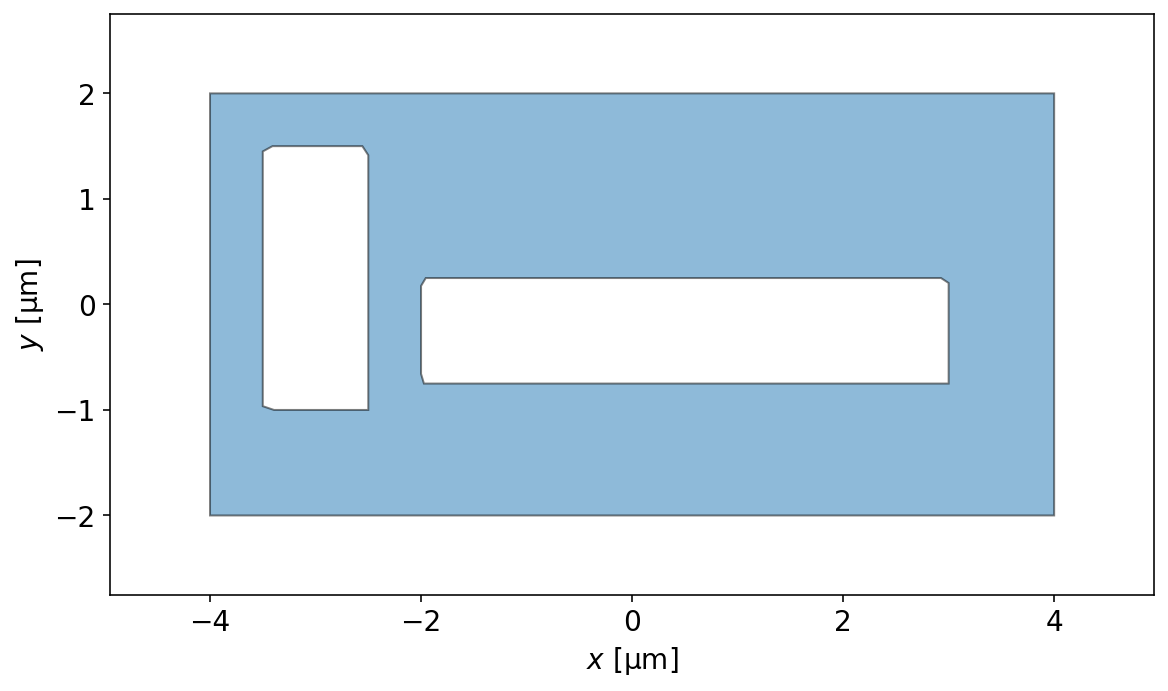

In [20]:
fig, ax = device.draw(exclude="bounding_box")

In [21]:
device.make_mesh(min_points=4_000, optimesh_steps=None)

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Finished generating mesh with 4084 points and 7971 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.device.device:Calculating gradient matrix.


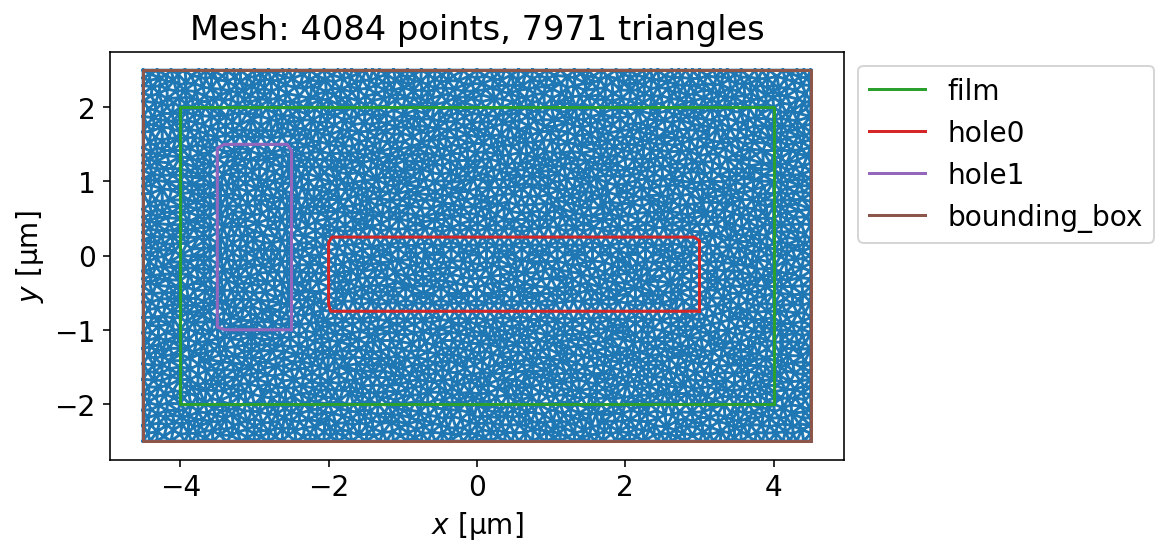

In [22]:
fig, ax = device.plot(mesh=True)
_ = ax.set_title(
    f"Mesh: {device.points.shape[0]} points, " f"{device.triangles.shape[0]} triangles"
)

### Full mutual inductance matrix

#### NumPy (CPU)

In [23]:
%timeit device.mutual_inductance_matrix(units="pH"); clear_output(wait=True)

5.54 s ± 31.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### JAX (CPU)

In [24]:
with jax.default_device(jax.devices("cpu")[0]):
    %timeit device.mutual_inductance_matrix(units="pH", gpu=True); clear_output(wait=True)

5.86 s ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### JAX (GPU if available)

In [25]:
if "cpu" in jax.devices()[0].device_kind:
    print("Skipping because there is no GPU available.")
else:
    %timeit device.mutual_inductance_matrix(units="pH", gpu=True); clear_output(wait=True)

5.13 s ± 42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
M = device.mutual_inductance_matrix(units="pH")
print(f"Mutual inductance matrix shape:", M.shape)
display(M)

INFO:superscreen.device.device:Evaluating 'rect' mutual inductance matrix column (1/2), source = 'hole0'.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.device.device:Evaluating fluxoids for solution 1/1.
INFO:superscreen.device.device:Evaluating 'rect' mutual inductance matrix column (2/2), source = 'hole1'.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.device.device:Evaluating fluxoids for solution 1/1.


Mutual inductance matrix shape: (2, 2)


Magnitude,[[6.411673813197213 -0.9926728089995721] [-0.9935563970136957 4.866195801494841]]
Units,picohenry


As promised, the mutual inductance matrix is approximately symmetric:

In [27]:
asymmetry = float(np.abs((M[0, 1] - M[1, 0]) / min(M[0, 1], M[1, 0])))
print(f"Mutual inductance matrix fractional asymmetry: {100 * asymmetry:.3f}%")

Mutual inductance matrix fractional asymmetry: 0.089%


### Model both holes in the $n=0$ fluxoid state

In [28]:
kwargs = dict(
    fluxoids=dict(hole0=0, hole1=0),
    applied_field=sc.sources.ConstantField(1),
    field_units="mT",
    current_units="mA",
)

#### NumPy (CPU)

In [29]:
# n = 0 fluxoid state, apply a field of 1 mT
%timeit sc.find_fluxoid_solution(device, **kwargs); clear_output(wait=True)

49.9 s ± 54.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### JAX (CPU)

In [30]:
%%timeit
with jax.default_device(jax.devices("cpu")[0]):
    # n = 0 fluxoid state, apply a field of 1 mT
    %timeit sc.find_fluxoid_solution(device, gpu=True, **kwargs); clear_output(wait=True)

35.9 s ± 314 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4min 49s ± 920 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### JAX (GPU if available)

In [31]:
if "cpu" in jax.devices()[0].device_kind:
    print("Skipping because there is no GPU available.")
else:
    %timeit sc.find_fluxoid_solution(device, gpu=True, **kwargs); clear_output(wait=True)

31.3 s ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
# n = 0 fluxoid state, apply a field of 1 mT
solution, result = sc.find_fluxoid_solution(
    device,
    fluxoids=dict(hole0=0, hole1=0),
    applied_field=sc.sources.ConstantField(1),
    field_units="mT",
    current_units="mA",
)
clear_output(wait=True)

INFO:superscreen.fluxoid:Finding fluxoid solution using least-squares minimization...
INFO:superscreen.fluxoid:Solving device with circulating_currents={'hole0': 0.0, 'hole1': 0.0}.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.fluxoid:Hole hole0: target = 0.000e+00 Phi_0, actual = 5.950e+00 Phi_0.
INFO:superscreen.fluxoid:Hole hole1: target = 0.000e+00 Phi_0, actual = 2.509e+00 Phi_0.
INFO:superscreen.fluxoid:Total cost = 4.169e+01 Phi_0 ** 2.
INFO:superscreen.fluxoid:Solving device with circulating_currents={'hole0': 1.4901161193847656e-08, 'hole1': 0.0}.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.fluxoid:Hole hole0: target = 0.000e+00 Phi_0, actual = 5.950e+00 Phi_0.
INFO:superscreen.fluxoid:Hole hole1: target = 0.000e+00 Phi_0, actual = 2.509e+00 Phi_0.
INFO:superscreen.fluxoid:Total cost = 4.169e+01 Phi_0 ** 2.
INFO:superscreen.fluxoid:Solving device with circulating_currents={'hole0': 0.0, 'hole1': 1.4

In [33]:
I_circ = solution.circulating_currents
fluxoids = [
    sum(solution.hole_fluxoid(hole)).to("Phi_0").magnitude
    for hole in ("hole0", "hole1")
]
print("Least-squares minimization result:\n", result)
print(f"Total circulating current: {I_circ} mA.")
print(f"Total fluxoid: {fluxoids} Phi_0.")

Least-squares minimization result:
       fun: 4.340223980661773e-15
 hess_inv: array([[0.05776505, 0.02622885],
       [0.02622885, 0.09858883]])
      jac: array([-1.33234042e-07, -5.79229282e-08])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([-2.15188944, -1.50549474])
Total circulating current: {'hole0': -2.151889436826825, 'hole1': -1.5054947298423187} mA.
Total fluxoid: [-5.865989460840382e-08, -6.010145991997007e-09] Phi_0.


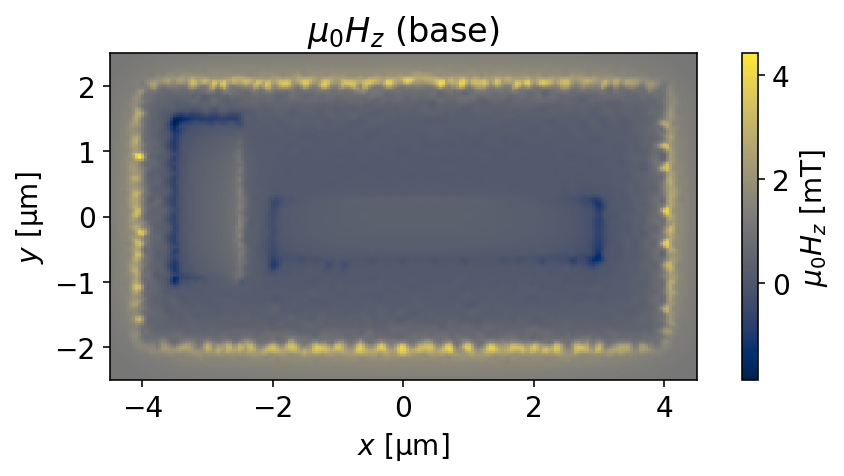

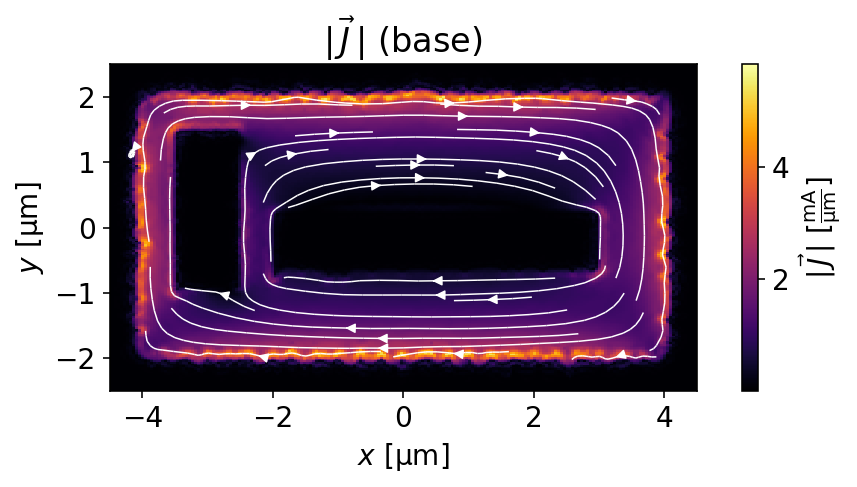

In [34]:
fig, axes = solution.plot_fields(figsize=(8, 3))
fig, axes = solution.plot_currents(figsize=(8, 3))

In [35]:
sc.version_table()

Software,Version
SuperScreen,0.6.1
Numpy,1.23.1
SciPy,1.8.1
matplotlib,3.5.2
ray,1.13.0
jax,0.3.15
IPython,8.4.0
Python,"3.9.12 (main, Jun 1 2022, 11:38:51) [GCC 7.5.0]"
OS,posix [linux]
Number of CPUs,"Physical: 2, Logical: 2"
